In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

In [2]:
def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C

def dpsidt(t,psi, H):
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H)
    #print("A = ",A)
    #print("psi = ",psi)
    return (-1*np.matmul(A,psi))

def rungeKutta(psi0, h, H, t = 2, t0 = 0, p = 0):
    
    n = (int)((t-t0))
    S = np.zeros((2,int(t)), dtype=np.complex_)
    r = 0
    
    for i in range(1 + p, n + 1 + p):
        
        S[0][r] = psi0[0][0]
        S[1][r] = psi0[1][0]
        
        k1 = dpsidt(t0, psi0, H)
        k2 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k1)), H)
        k3 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k2)), H)
        k4 = dpsidt(t0 + h, somar(psi0, np.dot(h, k3)), H)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        psi0 = somar(psi0,np.dot((h / 6.0),(C)))
    
        t0 = t0 + h
        
        r = r + 1
        
    return S

def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H2 = np.zeros((2,2), dtype=np.complex_)
    
    H1 = [[0, x[0]], [x[0], 0]]
    H2 = [[0, x[1]], [x[1], 0]]
    
    M = np.zeros((2,1),dtype=np.complex_)
    N = np.zeros((2,1),dtype=np.complex_)
    O = np.zeros((2,1),dtype=np.complex_)
    
    Result1 = np.zeros((2,1),dtype=np.complex_)
    Result2 = np.zeros((2,1),dtype=np.complex_)
    Result3 = np.zeros((2,1),dtype=np.complex_)
    
    M = psi0
    Result2 = rungeKutta(M, h, somar(H,H1), t = 2, t0 = 0, p = i)
    N = [[Result2[0][1]],[Result2[1][1]]]
    Result3 = rungeKutta(N, h, somar(H,somar(H1, np.dot(complex(0,1),H2))), t = 2, t0 = 0, p = i)
    O = [[Result3[0][1]],[Result3[1][1]]]
    
    Z = np.zeros((2,1),dtype=np.complex_)
    Y = np.zeros((2,1),dtype=np.complex_)
    W = np.zeros((2,1),dtype=np.complex_)
    
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    
    Y[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(i+1)/100)
    Y[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(i+1)/100)
    
    W[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(i+2)/100)
    W[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(i+2)/100)

    return (np.linalg.norm(Z-M)**2+np.linalg.norm(Y-N)**2+np.linalg.norm(W-O)**2)

def foS(x, alpha, d, D, H, i, psi0):
    
    z = x + alpha * d
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H2 = np.zeros((2,2), dtype=np.complex_)
    
    H1 = [[0, z[0]], [z[0], 0]]
    H2 = [[0, z[1]], [z[1], 0]]
    
    M = np.zeros((2,1),dtype=np.complex_)
    N = np.zeros((2,1),dtype=np.complex_)
    O = np.zeros((2,1),dtype=np.complex_)
    
    Result1 = np.zeros((2,1),dtype=np.complex_)
    Result2 = np.zeros((2,1),dtype=np.complex_)
    Result3 = np.zeros((2,1),dtype=np.complex_)
    
    M = psi0
    Result2 = rungeKutta(M, h, somar(H,H1), t = 2, t0 = 0, p = i)
    N = [[Result2[0][1]],[Result2[1][1]]]
    Result3 = rungeKutta(N, h, somar(H,somar(H1, np.dot(complex(0,1),H2))), t = 2, t0 = 0, p = i)
    O = [[Result3[0][1]],[Result3[1][1]]]
    
    Z = np.zeros((2,1),dtype=np.complex_)
    Y = np.zeros((2,1),dtype=np.complex_)
    W = np.zeros((2,1),dtype=np.complex_)
    
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    
    Y[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(i+1)/100)
    Y[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(i+1)/100)
    
    W[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(i+2)/100)
    W[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(i+2)/100)

    return (np.linalg.norm(Z-M)**2+np.linalg.norm(Y-N)**2+np.linalg.norm(W-O)**2)

In [3]:
def SecaoAurea(d, x, D, H, i, psi0):
    eps = 0.0000001
    a = 0
    b = 1
    xa = b - 0.618*(b-a)
    xb = a + 0.618*(b-a)
    fxa = foS(x, xa, d, D, H, i, psi0)
    fxb = foS(x, xb, d, D, H, i, psi0)
    
    while(b - a > eps):
        if(fxa < fxb):
            b = xb
            xb = xa
            xa = b - 0.618*(b - a)
            fxb = fxa
            fxa = foS(x, xa, d, D, H, i, psi0)
        else:
            a = xa
            xa = xb
            xb = a + 0.618*(b - a)
            fxa = fxb
            fxb = foS(x, xb, d, D, H, i, psi0)
            
    xp = (a+b)/2
    return xp

#Avaliação do gradiente
def gradiente(x, D, H, i, psi0):
    h = 0.00001
    grad = []
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + h
        dx = (fo(xh, D, H, i, psi0)-fo(x, D, H, i, psi0))/h
        grad.append(dx)
    return grad

In [4]:
def MetodoGrad(x, D, H, i, psi0):
    
    eps = 0.01
    errox = eps + 1
    xant = x.copy()
    
    k = 0
    kmax = 100
    normagrad = eps + 1
    
    CP = ''
    
    while(CP == ''):
        d = -1*np.array(gradiente(x, D, H, i, psi0))
        alpha = SecaoAurea(d, x, D, H, i, psi0)
        x = x + alpha * d
        
        errox = np.linalg.norm(xant - x)
        xant = x.copy()
        if(errox <= eps):
            CP = CP + 'Erro x'
        normagrad = np.linalg.norm(d)
        if(normagrad <= eps):
            CP = CP + 'Norma Gradiente'
        if(k >= kmax):
            CP = 'Numero de iteracoes'
            
        k += 1
        
    xOtimo = x
    return k, xOtimo, CP

In [5]:
x = []
x.append(random.uniform(-5., 5.))
x.append(random.uniform(-5., 5.))

i = 0

psi0 = [[complex(0.80,0)],[complex(0.60,0)]]
h = 0.01

E = np.zeros((2,2))
I = np.zeros((2,2))
R = np.zeros((2,2), dtype=np.complex_)
H = E.astype(complex)

A = (1/2*np.pi)
B = (3/2*np.pi)

I = [[1, 0], [0, 1]]
H = [[A, 0], [0, B]]
R = H

Resp = np.zeros((2,1000), dtype=np.complex_)

D = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

while i < 998:
    
    print("iteracao: ", i+1)
    
    Resp[0][i] = psi0[0][0]
    Resp[1][i] = psi0[1][0]
    
    resultado = MetodoGrad(x, D, H, i, psi0)
    
    x = []
    u = np.zeros((2,2))
    x.append(resultado[1][0])
    x.append(random.uniform(-5., 5.))
    
    u = [[0, resultado[1][0]],[resultado[1][0], 0]]
        
    i = i + 1
    H = somar(H, u)
    
    psi_t = np.zeros((2,2), dtype=np.complex_)
    
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0, p = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    print(psi0)
    print("-------------------")

iteracao:  1
[[(0.7982268069114494-0.039708035043328684j)], [(0.5975802889306545-0.06445953624115346j)]]
-------------------
iteracao:  2
[[(0.7929282204697344-0.07909155551152967j)], [(0.5903442499762591-0.12846409330520114j)]]
-------------------
iteracao:  3
[[(0.7863750180476067-0.11059598482882207j)], [(0.5799355079112433-0.1818176513861339j)]]
-------------------
iteracao:  4
[[(0.7807552758474333-0.1334030801483852j)], [(0.5681591674681703-0.22320387566345104j)]]
-------------------
iteracao:  5
[[(0.7780397102373291-0.14686500115743503j)], [(0.5566707640006736-0.2514011404382954j)]]
-------------------
iteracao:  6
[[(0.7792683756467276-0.15149051910149006j)], [(0.5465187118551037-0.2666621665750616j)]]
-------------------
iteracao:  7
[[(0.7846719934099295-0.1480870929712075j)], [(0.538212313639603-0.26960633008792373j)]]
-------------------
iteracao:  8
[[(0.7930717578283781-0.1390963268545391j)], [(0.5313938608605989-0.2632678398663827j)]]
-------------------
iteracao:  9
[[

[[(0.8125742376268155+0.05271076838720804j)], [(0.5802943713795979-0.014251881156565567j)]]
-------------------
iteracao:  72
[[(0.8138513916594611+0.0540450515176506j)], [(0.5781455591428709-0.0217427565669351j)]]
-------------------
iteracao:  73
[[(0.8153296414104244+0.05530069173803362j)], [(0.5756154825557336-0.02908978998785541j)]]
-------------------
iteracao:  74
[[(0.8170028339610983+0.056443506036972145j)], [(0.5727151855041454-0.036301604875123614j)]]
-------------------
iteracao:  75
[[(0.8188663128095015+0.057483582788966286j)], [(0.5694528255136105-0.04332515732291212j)]]
-------------------
iteracao:  76
[[(0.8209135336661519+0.0584093225935923j)], [(0.5658404198614488-0.050139114522573046j)]]
-------------------
iteracao:  77
[[(0.8231372636282158+0.05920954198654272j)], [(0.561891250504576-0.05672290750821005j)]]
-------------------
iteracao:  78
[[(0.8255296075266464+0.05987351422695907j)], [(0.5576198156943472-0.06305680606093868j)]]
-------------------
iteracao:  79

[[(0.8667264949321672-0.17987537905051634j)], [(0.46291734309487+0.04623368910198016j)]]
-------------------
iteracao:  144
[[(0.8627686583624106-0.18211539956442324j)], [(0.46948016446721025+0.045305497480840895j)]]
-------------------
iteracao:  145
[[(0.8588048991757924-0.1841334699638251j)], [(0.4760414899695438+0.04397157887332485j)]]
-------------------
iteracao:  146
[[(0.8548485690372153-0.1859299367406756j)], [(0.48257681220432735+0.04223259974013864j)]]
-------------------
iteracao:  147
[[(0.8509129736402019-0.18750595127848682j)], [(0.4890617082452393+0.040090704194667544j)]]
-------------------
iteracao:  148
[[(0.8470113242231291-0.1888634656098778j)], [(0.4954719286462818+0.03754950621443958j)]]
-------------------
iteracao:  149
[[(0.8431566894298075-0.19000522525636326j)], [(0.5017834858187004+0.03461407649578554j)]]
-------------------
iteracao:  150
[[(0.8393619476898398-0.1909347591764375j)], [(0.5079727414536593+0.03129092399968066j)]]
-------------------
iteracao:

[[(0.8844487222919992-0.22778756947675532j)], [(0.36070017794503106-0.189099580037585j)]]
-------------------
iteracao:  214
[[(0.8901173763503588-0.22257273890193516j)], [(0.36439147909340797-0.15928361671603222j)]]
-------------------
iteracao:  215
[[(0.8955228082515918-0.21335474568625024j)], [(0.3715809469574121-0.12019251157960553j)]]
-------------------
iteracao:  216
[[(0.8986141783818773-0.20367963756432858j)], [(0.38003274023432915-0.08113117033115705j)]]
-------------------
iteracao:  217
[[(0.8994010413889642-0.19343938003572347j)], [(0.389702118459071-0.04232278193620702j)]]
-------------------
iteracao:  218
[[(0.8979111623449987-0.18252978586851035j)], [(0.40052779044626785-0.003986990519221953j)]]
-------------------
iteracao:  219
[[(0.894190740191784-0.17085876649524684j)], [(0.41242941695272645+0.03364762263224002j)]]
-------------------
iteracao:  220
[[(0.8883029571454215-0.15832632856340378j)], [(0.42531804575107957+0.07039299384345984j)]]
-------------------
iter

[[(0.18342606331124253+0.040634593477565095j)], [(0.346387858007121-0.9190860108465287j)]]
-------------------
iteracao:  289
[[(0.15718948949790865+0.028592023832862298j)], [(0.30358275089445735-0.9393143284304385j)]]
-------------------
iteracao:  290
[[(0.13023433041763344+0.018218501086493977j)], [(0.2595673495213727-0.9567297577714804j)]]
-------------------
iteracao:  291
[[(0.10266925449463289+0.009556707670070597j)], [(0.2145246670441386-0.9712604145990769j)]]
-------------------
iteracao:  292
[[(0.07460544571767888+0.0026422629912590066j)], [(0.16864195325357556-0.9828463099637016j)]]
-------------------
iteracao:  293
[[(0.04615614510040644-0.002496423467454336j)], [(0.12210992231528077-0.9914395976436193j)]]
-------------------
iteracao:  294
[[(0.017436183656619083-0.0058382693152061495j)], [(0.0751219662221009-0.9970047714727426j)]]
-------------------
iteracao:  295
[[(-0.011438491181641162-0.007369606200676059j)], [(0.027873357202683247-0.9995188117755116j)]]
----------

[[(-0.5896606863717189-0.5518076358693333j)], [(-0.28325584755336347+0.5172761656610326j)]]
-------------------
iteracao:  354
[[(-0.6157635809594992-0.5512293498995299j)], [(-0.24032472972403532+0.5091417665483874j)]]
-------------------
iteracao:  355
[[(-0.641517299688983-0.5487936160240953j)], [(-0.19789648198225301+0.49811444549933726j)]]
-------------------
iteracao:  356
[[(-0.6667953011877897-0.5445273640848017j)], [(-0.15616913263279866+0.4842365893569138j)]]
-------------------
iteracao:  357
[[(-0.6914732048611579-0.5384661659005775j)], [(-0.11533733139192673+0.467564103312859j)]]
-------------------
iteracao:  358
[[(-0.7154293801487109-0.5306540662394285j)], [(-0.07559142759845738+0.448166146484382j)]]
-------------------
iteracao:  359
[[(-0.7385455227599139-0.5211433736619805j)], [(-0.03711656879432451+0.4261248047172524j)]]
-------------------
iteracao:  360
[[(-0.7607072151591286-0.5099944122272517j)], [(-9.182394376962277e-05+0.4015347021647266j)]]
-------------------

[[(0.3404869313516886-0.801955443045626j)], [(0.4558525328424483+0.18151995266587104j)]]
-------------------
iteracao:  419
[[(0.3288672336988519-0.8100186940122702j)], [(0.45890705457764114+0.15790909134410738j)]]
-------------------
iteracao:  420
[[(0.3128198859095858-0.8045131996147021j)], [(0.4840533713902364+0.1428617233675597j)]]
-------------------
iteracao:  421
[[(0.293503528850924-0.7842798969737501j)], [(0.5297580909003585+0.13391039100848295j)]]
-------------------
iteracao:  422
[[(0.27504177039013794-0.7615337689664466j)], [(0.573908937016481+0.12190889804904434j)]]
-------------------
iteracao:  423
[[(0.2576206722182599-0.7363728223023441j)], [(0.6162435409865101+0.10698343968187415j)]]
-------------------
iteracao:  424
[[(0.2414178896422188-0.7089105755124282j)], [(0.6565111976092317+0.08928127721676435j)]]
-------------------
iteracao:  425
[[(0.22660142022271368-0.6792752993907979j)], [(0.6944745804835277+0.06896970219025074j)]]
-------------------
iteracao:  426
[

[[(0.7065600853339332-0.011404637381668857j)], [(0.1735347839972986+0.6858157538248073j)]]
-------------------
iteracao:  487
[[(0.6719283569151129-0.012857033636499024j)], [(0.20706252526017657+0.7108353382404743j)]]
-------------------
iteracao:  488
[[(0.63613986966873-0.012074655454188107j)], [(0.24170774407781592+0.7325110382597896j)]]
-------------------
iteracao:  489
[[(0.599397617775968-0.008992499391521379j)], [(0.27719862095969194+0.7507445233302107j)]]
-------------------
iteracao:  490
[[(0.5619097648915418-0.0035623702710599423j)], [(0.3132564532932222+0.7654605818249374j)]]
-------------------
iteracao:  491
[[(0.5238882244927822+0.0042467570585478865j)], [(0.34959759516800526+0.7766076198261472j)]]
-------------------
iteracao:  492
[[(0.4855472148934194+0.014448495008417706j)], [(0.3859354317848565+0.7841579969803508j)]]
-------------------
iteracao:  493
[[(0.47581825706995046+0.012061716631216551j)], [(0.42242243045202027+0.7712493565396735j)]]
-------------------
it

[[(0.266113855373695-0.6646222325475982j)], [(-0.25260098523432434-0.6507443548827428j)]]
-------------------
iteracao:  556
[[(0.25945949921617056-0.6703319338583849j)], [(-0.27896817287566444-0.6366532763973317j)]]
-------------------
iteracao:  557
[[(0.2526276835382617-0.6760904643087021j)], [(-0.30460914377771087-0.6213766781543825j)]]
-------------------
iteracao:  558
[[(0.24561075269198798-0.6818904898539356j)], [(-0.3294686149290508-0.6049511705659847j)]]
-------------------
iteracao:  559
[[(0.2384013953313626-0.6877242353512307j)], [(-0.3534931352697575-0.5874159710569049j)]]
-------------------
iteracao:  560
[[(0.23099266645023836-0.6935835014092836j)], [(-0.37663120899100394-0.5688128126996833j)]]
-------------------
iteracao:  561
[[(0.22337800858829363-0.6994596822991086j)], [(-0.3988334142850317-0.5491858470158926j)]]
-------------------
iteracao:  562
[[(0.21555127215215839-0.7053437848832191j)], [(-0.4200525172724557-0.5285815411706061j)]]
-------------------
iteraca

[[(-0.6676823342336664-0.5946289982231482j)], [(0.3875097358939233+0.22420442476719182j)]]
-------------------
iteracao:  631
[[(-0.6781886715152042-0.5817117919968848j)], [(0.40104508973763514+0.20161626245978542j)]]
-------------------
iteracao:  632
[[(-0.6883537931661255-0.5685551223495913j)], [(0.41342237213337746+0.17835592182914067j)]]
-------------------
iteracao:  633
[[(-0.6981702055465601-0.5551713943135395j)], [(0.424609865514454+0.15448078656018294j)]]
-------------------
iteracao:  634
[[(-0.7076309580643205-0.5415733067511489j)], [(0.43457866635400133+0.1300497119426035j)]]
-------------------
iteracao:  635
[[(-0.7167296559382667-0.5277738267756127j)], [(0.44330275295847704+0.1051228873690764j)]]
-------------------
iteracao:  636
[[(-0.7254604717276046-0.513786163597813j)], [(0.4507590465523463+0.07976169572493208j)]]
-------------------
iteracao:  637
[[(-0.733818155601421-0.4996237418583194j)], [(0.4569274655133309+0.0540285699943632j)]]
-------------------
iteracao:

[[(0.10902636802370566-0.916090440430391j)], [(-0.38381493555422075+0.03731392186753077j)]]
-------------------
iteracao:  710
[[(0.09211631720716086-0.9352442922973307j)], [(-0.33636666536997667+0.05920168656530446j)]]
-------------------
iteracao:  711
[[(0.07393422901456605-0.9517621532508816j)], [(-0.2870898542186401+0.07795269335726232j)]]
-------------------
iteracao:  712
[[(0.05467875588829208-0.9655432371982002j)], [(-0.23626673531562653+0.09343014427428308j)]]
-------------------
iteracao:  713
[[(0.034556103727756526-0.9765039677144388j)], [(-0.18418993849465792+0.1055206735846707j)]]
-------------------
iteracao:  714
[[(0.013778594373100674-0.9845785446297219j)], [(-0.13116051329335635+0.11413512496458646j)]]
-------------------
iteracao:  715
[[(-0.007436813752344198-0.989719389809245j)], [(-0.07748589459507396+0.11920916292212j)]]
-------------------
iteracao:  716
[[(-0.028870036726471385-0.9918974690825562j)], [(-0.023477824715846043+0.12070371429840572j)]]
-----------

[[(0.8826333722539202+0.036828313799367615j)], [(0.18512387514035478-0.4302555796535405j)]]
-------------------
iteracao:  775
[[(0.8956464224257238+0.028043055167438158j)], [(0.16430644936275482-0.4120960700916831j)]]
-------------------
iteracao:  776
[[(0.9129751077899021+0.02043003907268662j)], [(0.14457997959527594-0.38071564457191565j)]]
-------------------
iteracao:  777
[[(0.9324706185033868+0.013181159870858078j)], [(0.12674011582984174-0.3377135626612441j)]]
-------------------
iteracao:  778
[[(0.9519685714479728+0.005761297252094219j)], [(0.11147100740067889-0.28475526771740833j)]]
-------------------
iteracao:  779
[[(0.969318999419095-0.0021850869083556226j)], [(0.09934065114518105-0.2243569360240651j)]]
-------------------
iteracao:  780
[[(0.9829004025644901-0.010768843921658314j)], [(0.09075495482611241-0.15919503800624663j)]]
-------------------
iteracao:  781
[[(0.9917193925573982-0.019943014781313197j)], [(0.08593166589524259-0.09219195626056881j)]]
----------------

[[(0.6568399142493809+0.25052122500103224j)], [(0.7019698450013062-0.11325813728945448j)]]
-------------------
iteracao:  849
[[(0.6653487818435759+0.26649566882943027j)], [(0.6866337875106261-0.12088723968136672j)]]
-------------------
iteracao:  850
[[(0.6743608002390595+0.2816668632414542j)], [(0.6703972552885444-0.12750464706825118j)]]
-------------------
iteracao:  851
[[(0.6830957580355597+0.292171693112853j)], [(0.654995002985232-0.1370622438589042j)]]
-------------------
iteracao:  852
[[(0.6922667471188+0.3019707626781964j)], [(0.6388688212966942-0.14565597786196063j)]]
-------------------
iteracao:  853
[[(0.7017189846536778+0.31055819201840523j)], [(0.6223204998313373-0.1537852291224872j)]]
-------------------
iteracao:  854
[[(0.7113335330393908+0.31766088045718965j)], [(0.6055684286365429-0.16177661505821647j)]]
-------------------
iteracao:  855
[[(0.7211520548616472+0.3236485153709456j)], [(0.5885058840125011-0.16923593524038905j)]]
-------------------
iteracao:  856
[[(

[[(0.7935369785112695-0.06148099932361752j)], [(0.4886237287777092+0.357147899027085j)]]
-------------------
iteracao:  917
[[(0.7835074540342931-0.06117523332211857j)], [(0.5069442166999516+0.35379350052556346j)]]
-------------------
iteracao:  918
[[(0.773587362920227-0.06024804455499192j)], [(0.5250646212010679+0.34932581938877466j)]]
-------------------
iteracao:  919
[[(0.7638146172232679-0.058707418971131256j)], [(0.5429170540261457+0.3437591617759143j)]]
-------------------
iteracao:  920
[[(0.7542265677625112-0.05656365240735136j)], [(0.5604346319086474+0.337111970064376j)]]
-------------------
iteracao:  921
[[(0.7448598635275798-0.05382931182383294j)], [(0.577551728326692+0.32940675343577597j)]]
-------------------
iteracao:  922
[[(0.735750313726146-0.050519187990953604j)], [(0.5942042205287795+0.32067000315379285j)]]
-------------------
iteracao:  923
[[(0.7312420671415536-0.05491625152518711j)], [(0.6094789403843632+0.3009871838749708j)]]
-------------------
iteracao:  924

[[(0.3587585272056634-0.6515653642028705j)], [(-0.5624420170422861-0.36083581785800245j)]]
-------------------
iteracao:  989
[[(0.34869509757518397-0.6574798796110051j)], [(-0.5783994633272834-0.33372835097420334j)]]
-------------------
iteracao:  990
[[(0.33852269311156225-0.6632450694446997j)], [(-0.5930587439968285-0.3059057122616193j)]]
-------------------
iteracao:  991
[[(0.3282432497938825-0.6688584121076737j)], [(-0.6063877070419349-0.27742991316302773j)]]
-------------------
iteracao:  992
[[(0.3178587824985812-0.6743173977794932j)], [(-0.6183571588349135-0.2483644095714378j)]]
-------------------
iteracao:  993
[[(0.3073713856525499-0.6796195315375944j)], [(-0.6289409288784013-0.21877396081810901j)]]
-------------------
iteracao:  994
[[(0.29678323374743104-0.684762336527276j)], [(-0.6381159278376836-0.18872448576659964j)]]
-------------------
iteracao:  995
[[(0.28609658171238267-0.6897433571723254j)], [(-0.6458621987283679-0.158282916332953j)]]
-------------------
iteracao

In [6]:
len(Resp[0])

1000

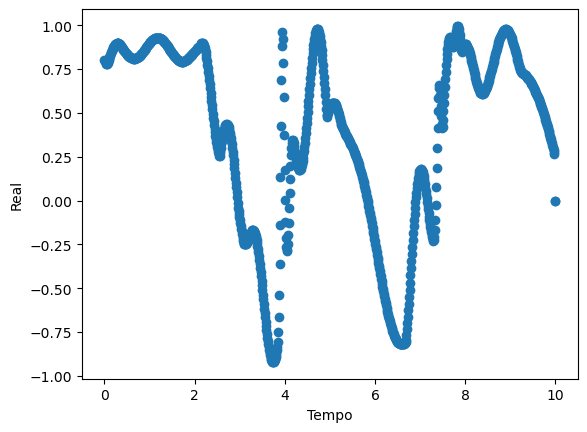

In [7]:
ts = np.linspace(0, 10, 1000)

x = [ele.real for ele in Resp[0]] 
y = [ele.imag for ele in Resp[0]] 

plt.scatter(ts, x) 
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.show()